
<center>PyPEF – an Integrated Framework for Data-driven Protein Engineering</center>
<br><center>Niklas E. Siedhoff<sup>1,§</sup>, Alexander-Maurice Illig<sup>1,§</sup>, Ulrich Schwaneberg<sup>1,2</sup>, Mehdi D. Davari<sup>1,*</sup></center></br>

<center><sup>1</sup>Institute of Biotechnology, RWTH Aachen University, Worringer Weg 3, 52074 Aachen, Germany</center>

<center><sup>2</sup>DWI-Leibniz Institute for Interactive Materials, Forckenbeckstraße 50, 52074 Aachen, Germany</center>

<center><sup>§</sup>Contributed equally to this work, <sup>∗</sup>Corresponding author</center>

<br><center>To be published</center></br>

### Machine learning-assisted protein engineering framework "PyPEF" v. 0.1 
October 2020
#### by Niklas Siedhoff and Alexander-Maurice Illig



## General Description

In the following, the reported version of the machine learning framework PyPEF is presented. The tool is written in Python 3 and inteded for executing it in command-line interpreters or exemplary **for running inside this Notebook, see [Running in Terminal](#Running-in-Terminal)** for testing the running commands. The code cells up to this section give a brief overview over the main programs functions. A general workflow of this tool is presented and described hereinafter (see Figure 1).

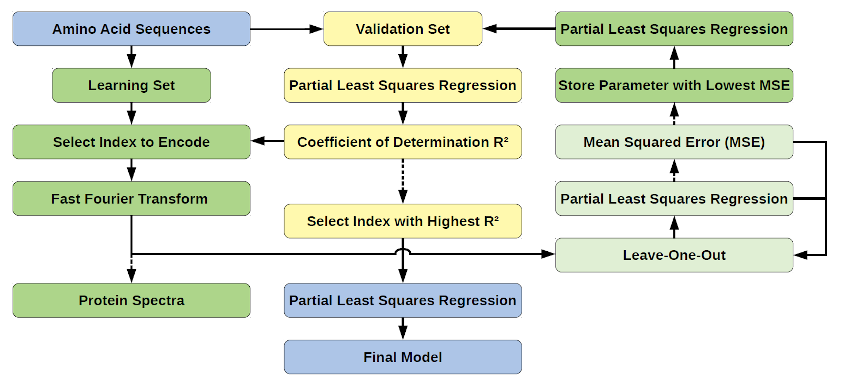
**Figure 1:** Schematic overview of the PLS-based algorithm: Blue components refer to the whole dataset size, yellow to the validation dataset and green to the learning dataset. Light green refers to the process of leave-one-out cross-validation (LOOCV) at which the learning dataset size is reduced by 1.

The developed algorithm encompasses the automatized transformation of the given input sequences into numerical values using AAindex databank entries, the Fourier transform of the numerical sequences to protein spectra, leave-one-out cross-validation for selecting the best model hyperparmeter, and consequently estimating model performance on a validation dataset. 
Finally, the trained machine is used for estimating the fitness value of every given variant of length $N$, $N$ being the number of variant amino acids, in the unknown sequence space. The first step of the algorithm signifies the transformation of the given input sequences into numerical values. This conversion is performed for all entries of the AAindex database with the minimum availability of all 20 naturally encoded amino acids (a list of all 566 indices can be obtained from https://www.genome.jp/aaindex/AAindex/list_of_indices), so that the matrix $\mathbf{F} \in \mathbb{R}^{1 \times N}$ is established with $x_n$ being the value of the $n$-th entry:

$$ \mathbf{F} = \left(\begin{matrix} x_{0} & x_{1} & \dots & x_{N_{\mathrm{seq}-1}} \end{matrix}\right) $$

Each of the $N$ values is then normalized ($\tilde{x}$) following

$$ \tilde{x}_n = x_{n} - \overline{x} \ ,$$ 

with

$$ \overline{x} = \frac{1}{N} \sum_{n=0}^N x_n \ ,$$

so that artifacts of the Fourier transform can be avoided. The implemented fast Fourier transform (FFT) algorithm constraines $\mathbf{F} \in \mathbb{R}^{1 \times N_\mathrm{Dim}}$ to the condition

$$ N_\mathrm{Dim}\overset{!}{=}2^k, k \in \mathbb{N} \ .$$


If $N$ does not hold for the upper equation, $\mathbf{F}$ is reshaped by adding columns of zeros ("zero padding") until the condition is fulfilled. This normalized (and zero padded) matrix ($\mathbf{\tilde{F}}$) is then FFT-ed following

$$ \left|\hat{F}_j\right| = \left|\sum_{n=0}^{N_{\mathrm{Dim}}-1} \tilde{x}_{n} \exp \left( -\frac{2 \pi i j n}{N_{\mathrm{Dim}}} \right) \right| \ , \hat{F}_j \in \mathbb{C} \ , $$

with spectrum frequencies $j \in [0, 1, …, N_{\mathrm{Dim}}–1]$ and the imaginary number $i^2 = \, – 1$. A following plot of a normalized protein spectrum is presented in Figure 2. Since $\hat{F}_{N-j} = (\hat{F}_j)^*$, the FFT spectrum is mirrored at $0.5 \, j_{\mathrm{max}}$, as a result there is no need to use all frequencies for learning to obtain the saturated information content.

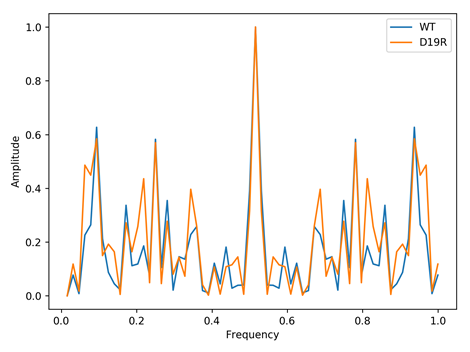

**Figure 2:** FFT protein spectra (of the peptide liquid chromatography peak I, LCI, wild-type (blue) and variant D19R (orange)). 

The spectrum amplitudes represent the independent variables and are used as input for the PLS regressor. $y$ is usually expressed as variant's (V) relative fitness value normalized to the wild-type (WT), i.e. $y = \frac{y_\mathrm{Variant}}{y_\mathrm{Wild-type}}$. The PLS regressor is fed with all except one input variant spectra. Then, the trained PLS model is used for predicting the label of the left-out variant. For $m$ given input sequences as learning dataset this process is performed $C_m^1 = m$ times. For all predictions ($y$) of $y_\mathrm{true}$ building up the vector of the length $m$, the MSE is calculated following:

$$ \mathrm{MSE} =  \frac{1}{m} \sum_{i=1}^{m} (y_{\mathrm{true},i} - y_{i})^2 \ .$$   
    
The model hyperparameter ‘n_components’, the number of components in the PLS regression, is increased by 1 after every MSE loop up to ‘n_components’ reaching 10. An exemplary plot for the iteration of the number of components is shown in Figure 3. Here, the final model for the taken AAindex would be trained using 4 as the number of components for PLS regression.
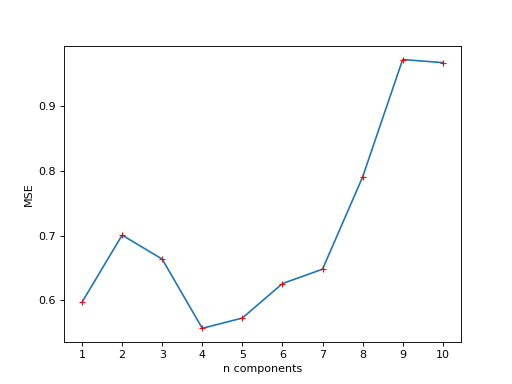

**Figure 3:** Exemplary plot of the mean-squared error for the iteration over the number of components for PLS regression.

For more information about estimating the number of components in PLS regression and the trade-off of overfitting and good predictions see other articles, e.g. <a href="https://www.sciencedirect.com/science/article/pii/0003267086800289" target="_blank">Link-1</a> and <a href="https://arxiv.org/pdf/1810.08104.pdf" target="_blank">Link-2</a>. For every AAindex, the model with the lowest MSE is stored. The best performing numbers of components are used for training the 566 PLS regressors on the whole learning dataset (one variant more than in the LOOCV training dataset) and predicting the label of a given yet unseen validation dataset. The quality of these predictions are determined by calculating the $R^2$ score and RMSE of the predicted observations ($y_\mathrm{pred}$) and the measured fitness values ($y_\mathrm{obs}$) following

$$ R^2 = \frac{\sum_{i=1}^{N} ({y_{\mathrm{pred},i} - \overline{y}_{\mathrm{obs}})^2}}{\sum_{i=1}^{N} ({y_{\mathrm{obs},i} - \overline{y}_{\mathrm{obs}}})^2} \ ,$$ 
and 
$$ RMSE = \frac{1}{N} \sum_{i=1}^{N} (y_{\mathrm{obs},i} - y_{\mathrm{pred},i})^2 \ ,$$ 
while we defined the normalized RMSE (NRMSE) as 
$$ NRMSE = \frac{RMSE}{\sigma} \ ,$$
with $$ \sigma = \sqrt{\frac{\sum_{i=1}^{N}({y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs}})^2}{N-1}} \ ,$$
respectively,
and the Pearson corellation coefficient $r$ being defined as
$$ r_\mathrm{Y_\mathrm{obs}, Y_\mathrm{pred}} = \frac{cov(Y_\mathrm{obs}, Y_\mathrm{pred})}{{\sigma_Y}_\mathrm{obs}{\sigma_Y}_\mathrm{pred}}
= \frac{\sum_{i=1}^{N}{(y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs})(y_{\mathrm{pred},i} - \overline{y}_\mathrm{pred})}}
{\sqrt{\sum_{i=1}^{N}({y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs}})^2}
\sqrt{\sum_{i=1}^{N}({y_{\mathrm{pred},i} - \overline{y}_\mathrm{pred}})^2}}
 \ ,$$
where $N$ defines the number of variants in the validation set.

The user specifies a threshold for the number of saving the *s* best models according to the $R^2$ score on the validation dataset (also see [Cadet *et al.*](https://www.nature.com/articles/s41598-018-35033-y)). These *s* best models will be dumped as pickle files and can easily be reloaded for predictions on new variants sequence space later on. After validation and optional viszualization of the measured and predicted observations (see Figure 4), the final model can optionally be trained on the whole dataset. An exemplary plot of a validation routine is shown hereinafter.

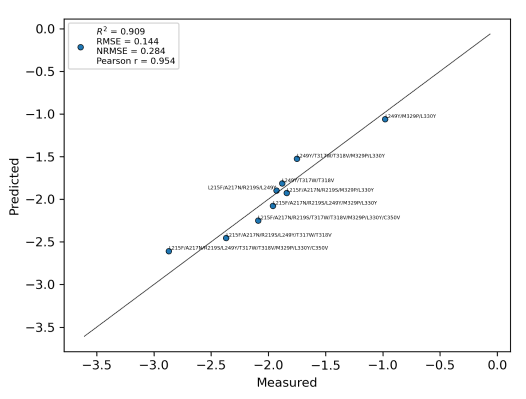

**Figure 4:** Validaton plot of predicted vs. measured entries of the validation dataset.

##### Performing predictions

Predictions using trained models can be performed on pure recombinant or natural diverse sequence data. However, as the sequence space to screen drastically increases for the number of simultaneously added mutation sites, we added the possiblity to explore the unknown variant space performing a random walk on diverse *in silico* directed evolution paths as described and presented by [Biswal *et al.*](https://www.biorxiv.org/content/10.1101/2020.01.23.917682v2); the corresponding code can be explored here: [GitHub repository](https://github.com/ivanjayapurna/low-n-protein-engineering) and exemplary [Jupyter Notebook](https://github.com/ivanjayapurna/low-n-protein-engineering/blob/master/directed-evo/DE_notebook.ipynb).

After randomly chosing and accepting a first mutation in a sequence, subsequently, substitutions will be added when meeting an update criterion that is defined by the Metropolis-Hastings algorithm. Here, the Metropolis choice for acception (when setting the Boltzmann constant $k$ to one) is defined as:
$$ A = min(1,exp(\frac{\Delta y_\mathrm{pred}}{T})) \ ,$$

with $T$ being the "Temperature" of the "Boltzmann-distributed" system and ($\Delta y_\mathrm{pred}$) being the difference ($y^*_\mathrm{pred} - y_\mathrm{pred}$) of the newly predicted ($^*$) sequence fitness and the fitness of the sequence variant predicted before, respectively.
If we plot $\Delta y_\mathrm{pred}$ against $exp(\frac{\Delta y_\mathrm{pred}}{T})$ we can see the influence of the Temperature on the acceptance ratio (see Figure 5).

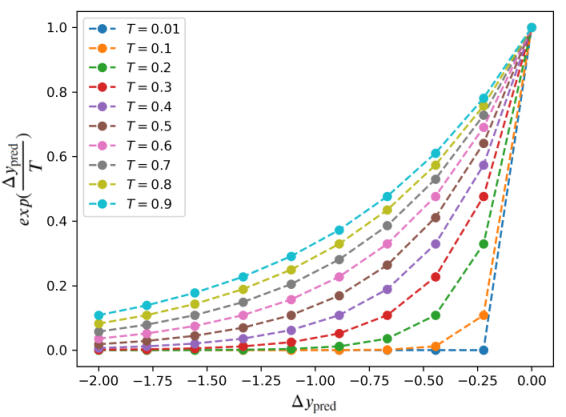

**Figure 5:** Influence of different temperatures on acceptance graph.

Then we roll a dice to randomly select a number $u$ between 0 and 1 ($u \in [0,1]$). If $u \leq A$, the new state, that is the new sequence with $y^*_\mathrm{pred}$, gets accepted; else, i.e. if $u \gt A$, the new sequence will be rejected and the old will be kept. Instead of allowing more than a single substitution per iteration in evolution, we kept the number of introduced substitution per round at one.  

## Start of code explanantion
##### (only for Modules_PLSR.py as this .py script contains the relevant machine learning functions for feature engineering, learning, and validation)

### Section 1: Argument parsing and import of Modules
 The docstring of the program is used for argument parsing and thus necessary for running the commands.

For performing the program routine, it is necessary to load some functions from the modules .py scripts.
All library requirements are listed in the <b>requirements.txt</b> file.
<ul>
<li>numpy==1.17.3</li>
<li>pandas==1.1.0</li>
<li>scikit-learn==0.21.3</li>
<li>scipy==1.3.1</li>
<li>matplotlib==3.1.1</li>
<li>docopt==0.6.2</li>
<li>tqdm==4.41.1</li>
<li>adjustText==0.7.3</li>
For parallel running:    
<li>ray==0.7.6</li>
<li>setproctitle==1.1.10</li>
<li>psutil==5.7.2</li>
</ul>

Function `run()` then gets the arguments from docopts and runs diverse modules when the regarding flags have been put by the user following the scheme:

Here, docopts (http://docopt.org/) is used as argument parser which uses the docstring of the prgram itself for getting the possible commands and thus is used as parser for user-defined command-line arguments. NumPy (https://numpy.org/) is used for scientific computing (e.g. feature data transformation). Scikit-learn (`sklearn`, https://scikit-learn.org/stable/index.html) is used for performing machine learning tasks, i.e. performing leave-one-out cross-validation (LOOCV, `LeaveOneOut`) using partial-least-squares (PLS) regression (`PLSRegression`) calculating the mean-squared-error (MSE, `mean_squared_error`) on the LOOCV data splits and finally for estimating the performance of the hyperparameter-tuned PLS regressor on the given validation set calculating the $R^2$ (`r2_score`) an the RMSE. For parallelization of independent iterative tasks of the program routine (the iteration over the number of components over all 566 entries of the AAindex), parallel running uses Ray (https://ray.readthedocs.io/en/latest/#) that supports Linux and MacOS (Windows support announced). Parallel running can be achieved by using the optional flags `--parallel -c` for specifying the number of CPUs to be used. 

Parallel running follows the run command, e.g. to use 4 cores you can define:
<br>`python3 pypef.py run -l LS.fasta -v VS.fasta -s 5 --parallel -c 4`
<br>In the following, mainly the non-parallelized version of this tool is described.

### Imported Modules from Modules_PLSR.py

To get a deeper insight into the program routine, the functions of each imported module (i.e. classes and functions) from Modules.py are shortly depicted in the following. For a more detailed description of each module see code. The program routine follows after description of the imported modules.

##### read_models
Function *read_models* just reads and prints the models found in the file *Model_Results.txt*. If no model was trained, the file does not exist.

##### Full_Path
Function *Full_Path* returns the path of an index inside the folder */AAindex/*, e.g. *path/to/AAindex/FAUJ880109.txt*.

##### Path_AAindex_Dir
Function *Path_AAindex_Dir* returns the path to the */AAindex* folder, e.g. *path/to/AAindex/*.

##### AAindex
Class *AAindex* can be used to get all the information that are given in each AAindex file. For the program routine it provides the library to enable translation of the alphabetical amino acid sequence to an array of numericals.

##### Get_Sequences
The function *Get_Sequences* is used to read the given datasets, i.e. the learning and the validation dataset in FASTA format and it returns the name of the variant (`Name_Of_Mutation`), the sequence of the variant (`Sequence`), and the corresponding fitness value (i.e. relative fitness to wild-type, `Value`) in an array. An example of an appropriate input dataset is given below in the explanation of the [Program routine](#Program-Routine). For performing predictions (`Prediction=True`) no sequence label (`Values`, defined by lines starting with `';'`) is needed.

##### XY
The Class *XY* is used for 

- converting the string sequence into a list of numericals using the AAindex translation library,
- Fourier transforming the numerical array that was translated by *Get_Numerical_Sequence* (*Do_Fourier*),
- computing the input matrices $X$ and $Y$ for the PLS regressor (*Get_X_And_Y*)

##### Get_R2
The function *Get_R2* takes features and labels from the learning and validation set. The MSE is calculated for all LOOCV sets for predicted vs true labels  (`mse = mean_squared_error(y_test_loo, y_pred_loo`) for a fixed number of components for PLS regression. In the next iteration, the number of components is increased by 1 (`number_of_components += 1`) and the MSE is calculated for this regressor. The loop breaks if `i > 10`. Finally, the model of the single AAindex model with the lowest MSE is chosen:

`idx = np.where(Mean_Squared_Error == np.min(Mean_Squared_Error))[0][0] + 1`;

`pls = PLSRegression(n_components=idx)`.

The function returns the $R^2$, the (N)RMSE, and the Pearson $r$ of the model. 

##### R2_List
Function *R2_List* returns the sorted list of all the model number of components and the $R^2$ and RMSE values from function *Get_R2*. 

##### Formatted_Output
Function *Formatted_Output* takes the sorted list from function *R2_List* and writes the model names with an $R^2 \geq 0$ as well as the corresponding number of components for each model so that the user gets a list (*Model_Results.txt*) of the top ranking models for the given validation set. 

##### Save_Model
Function *Save_Model* saves the best `-s THRESHOLD` models as 'Pickle' files (`pickle.dump`), which can be loaded again for doing predictions. Also, in *Save_Model* included is the computing of the $k$-fold CV performance of the n component-optimized model on all data (learning + validation set); by default $k$ is 5 (`n_samples = 5`). Plots of the CV performance for the *t* best models are stored inside the folder *CV_performance*. 

##### Predict
The function *Predict* is used to perform predictions. Saved pickle files of models will be loaded again (`mod = pickle.load(file)`) and used for predicting the label $Y$ (`Y = mod.predict(X)`) of sequences given in the Prediction_Set.fasta.

##### Predictions_Out
Finally, predictions (of the new sequence space) are written to a text file.

##### Plot
Function *Plot* is used to make plots of the validation process and shows predicted (`Y_pred`) vs. measured/"true" (`Y_true`) protein fitness and calculates the corresponding $R^2$ and RMSE.

The further functions `mutate_sequence`, `restructure_dict`, `write_MCMC_predictions`, `in_silico_de`, and `run_DE_trajectories` call these functions described above to apply a Monte Carlo method for performing an *in silico* directed evolution applying the Metropolis-Hastings algorithm. Here, the functions get called to write the randomly selected sequences files, to predict these sequences fitness, and to accept this sequence for further rounds of substitution - or, when not meeting the criterion, to reject them.

## Program Routine

Generally, the routine is typical for performing supervised machine learning tasks:
1. Implementation (and transformation) of feature ($\mathrm{X}$) and label ($\mathrm{Y}$) data
2. Selection of model
3. Training on a learning set (searching for the model parameter values that minimize the cost function)
4. Validation/estimation of model performance on validation dataset 
5. Use trained model for making predictions on new cases ("*inference*")

Remark: When no representative validation dataset can easily be chosen for the given task, a testing of different learning and validation datasets performing *k*-fold datasplits and taking the mean performance might be a more ideal way to follow for finding the best model for performing predictions of new cases.

##### Argument Parsing

`docopts` is used for creating parser objects which can be filled with user commands. Only four major commands exist:
`python3 pypef.py mklsvs`, `mkps`, `run`, and `directevo`.


- For creation of Learning  (LS) and Validation Sets (VS) you can use the `mklsvs` command which uses the .csv file as variant and label data input
- For creation of Prediction Set(s) (PS) you can use the `mkps`command which creates recombinant (or natural diverse (`--ddiverse`, `--tdiverse`, or `--qdiverse`)) prediction sequence sets form the input .csv file.
- Using `run` the user can
- <b>1.</b> train models; required are the specification for learning set (`-l path/to/Learning_Set.fasta`) and validation set (`-v path/to/Validation_Set.fasta`). Also, the user can define how many of the best `t` models in terms of $R^2$ for the validation dataset he wants to save as pickle files (`-s`); by default, `t` is set to 5.
- <b>2.</b> plot the validation datasets; the user can specify the model he wants to use (`-m MODEL12345`) for plotting the validation on the *Validation_Set.fasta* (`-f path/to/Validation_Set.fasta`).
- <b>3.</b> perform predictions; the user can specify a trained model (`-m MODEL12345`) and the *Prediction_Set.fasta* (`-p path/to/Prediction_Set.fasta`) to perform predictions on.    

For creating the LS and VS or PS you can use the mklsvs and the mkps command, respectively. For fasta style output see the *Learning_Set.fasta* and *Validation_Set.fasta* files. The learning and validation sets are defined similar to the FASTA format of protein sequence files and has to follow the definition:

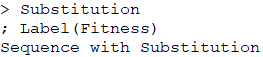

, e.g.
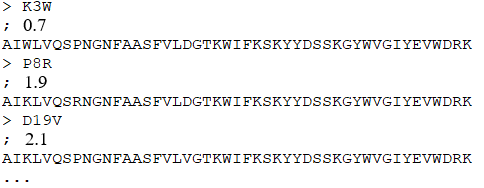

Main Execution using `run` sets output path to the current working directory. 
If learning and validation sets are given, the script runs model training and performance evaluation; the best (`-s`) models will be stored as pickle files inside the created subdirectory */Pickles*;
If validation .fasta is given with selected model, the validation is plotted using the selected model for predictions on the validation dataset.
If prediction set and selected model are given the program will perform predictions on sequences given in the prediction .fasta. 

## Running in Terminal

Before running this protocol it is advised to create a new Python 3 environment, e.g. using [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).
For this exemplary protocol we run our workflow on the ANEH set reported by [Gumulya, Sanchis, and Reetz]( https://doi.org/10.1002/cbic.201100784). For training, validating, and predicting the relative energy ($\Delta\Delta G^{\neq}$) of the ANEH variants
the tool is run following a typical machine learning approach and comprises three steps:
***
1. Learning and model validation: `python3 path/to/pypef.py run -l path/to/Learning_Set.fasta -v path/to/Validation_Set.fasta -s 10`
2. Visualization: `python3 path/to/pypef.py run -f Validation_Set.fasta -m MODEL12345`
3. Prediction: `python3 path/to/pypef.py run -p Prediction_Set.fasta -m MODEL12345`
***

##### Exemplary running in Jupyter Notebook
We tested this Notebook running on Python 3.7.9. To check your current working directory, this should be inside the folder *workflow* at this point.

In [1]:
# run this Cell first to save the script directory; here your working directory should be the folder "path/to/workflow".
# if not, change directory, e.g. using %cd or os.chdir() or run this Cell a second time:
# If you changed the current working dir, this will take you back to the workbook dir.
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('Current Working Directory: ' + workbookDir)
os.chdir(workbookDir)  
if workbookDir[-8:] != "workflow":
    try:
        os.chdir(os.getcwd().split("workflow",1)[0] + "workflow")
        print("You are here \"{}\", You should be in the workflow directory for\
        running the script when starting from here!").format(os.getcwd())
    except:
        print("You are here \"{}\", please change path to /workflow directory.".format(os.getcwd()))
else:
    print("You are in the correct directory for running the script when starting from here!")
   

Current Working Directory: C:\Users\n.siedhoff\sciebo\Manuscripts\ML_Method_Paper\GitHub\workflow
You are in the correct directory for running the script when starting from here!


Installing required Python modules using pip. If you don't want to change your current Python Environment, better create a new one (e.g. using Conda) and run then run the cell below.
To install parallel modules (Ray, setproctitle) on Windows, Visual C++ 14.0 is required. More on this later in the following.

In [ ]:
# Install packages in the current Jupyter kernel using pip
%run -m pip install --user -r ../requirements.txt

In [ ]:
%run ../src/pypef.py -h

Create LS and VS datasets:

In [ ]:
%cd test_dataset/

In [ ]:
%run ../../src/pypef.py mklsvs -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fa

(Also, you can test all 150 variants (`-i 150_ANEH_variants.csv` or directly use prepared LS_B.fasta and VS_B.fasta for running) but running will take much longer.) Now, LS and VS sets as .fasta text files were created in the folder.

Next, you can 
run model training and validation and saving 10 best models (using single CPU):

In [ ]:
%run ../../src/pypef.py run -l LS.fasta -v VS.fasta -s 10

##### <font color='red'>This section may not work (when running on Windows)</font>

For Unix-like systems (macOS, Linux) the use of Ray (https://docs.ray.io/en/latest/index.html) is supported and for parallel running you can define the flag `--parallel` and the number of cores to be used `-c CNUMBER`. For Windows, Ray is not yet fully supported (see [Ray for Windows](https://docs.ray.io/en/latest/installation.html#windows-support) for more information). For running on Windows you may need to install the latest version of [Visual C++](https://support.microsoft.com/en-us/help/2977003/the-latest-supported-visual-c-downloads).

In [ ]:
%run -m pip install --user -r ../../requirements_parallelization.txt

In [ ]:
# To avoid potential system instabilities, just run parallel in Unix System (Shell)
# using 4 cores for running (-c 4)
%run ../../src/pypef.py run -l LS.fasta -v VS.fasta -s 10 --parallel -c 4

##### <font color='red'>Section end</font>

The output of the validation (of the entries in *Validation_Set.fasta*) is written to *Model_Result.txt* and furthermore, the 5-fold CV performance for each of the `-s TRESHOLD` models is plotted and stored in the folder *CV_performance*. Obviously, the computed $R^2$ heavily depends on the positional information content of the splitted learning and validation datasets. Note that a high number of components for a model might be a sign of overfitting; here the testing of *k*-fold datasplits might be helpful as indicator of possible overfitting (see folder *CV_performance*).
The best models are reported in the *Model_Results.txt* file; we can also show the model results using 

In [ ]:
%run ../../src/pypef.py --show

Next, one can plot the prediction on the validation dataset; e.g. for validating the predictions of the best model, i.e. index FAUJ880104 having an $R^2$ = 0.909 and an RMSE = 0.144. For visualization run command cell below and see the stored *.png* image.

In [ ]:
%run ../../src/pypef.py run -m FAUJ880104 -f VS.fasta

Or, you can save a labeled plot which uses adjustText (https://github.com/Phlya/adjustText/wiki) which iteratively tries to adjust the labels of the variants (can take a long time for some close/crowded data points).

In [ ]:
%run ../../src/pypef.py run -m FAUJ880104 -f VS.fasta --label

The saved images should look similar to these plots (left: unlabeled, right: labeled):

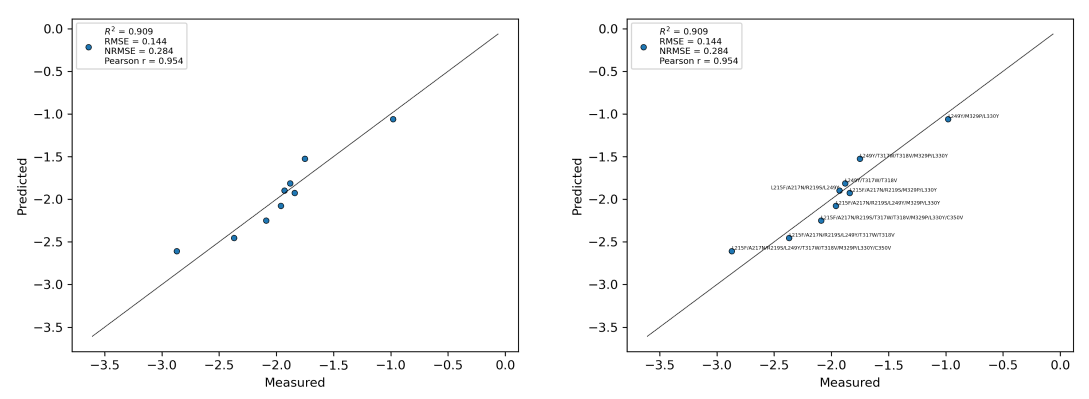


Or, to plot a colored version that divides the predicted variants in the classification categories false positive (FP, top left), true positive (TP, top right), true negative (TN, down left), false negative (FN, down right), try:

In [ ]:
%run ../../src/pypef.py run -m FAUJ880104 -f VS.fasta --color -y -1.5

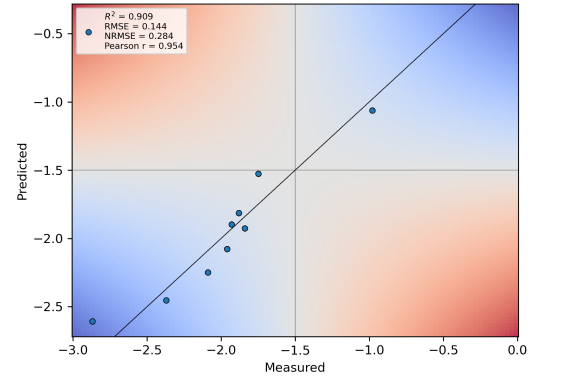


#### Making predictions
Finally, one can predict new variants of the unknown sequence space, e.g. by predicting double or triple substitutional variants with single substitutional recombinant (or full natural) diversity. For simplified prediction set generation one can use the `mkps` function.

In [ ]:
%run ../../src/pypef.py mkps -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fa

Now we got an error as we did not specify which recombinants we want to test. Exemplary, we can define the flag `--drecomb` and `trecomb`for establishing double and triple substitutional recombinant sequence variants; diverse sequence variants can be established using the keyword 'diverse', e.g. defining the flag `--tdiverse` (attention: diverse sets creation can take a long time and can require much hard drive space dependent on the number of single substitutional variants and sequence length):

In [ ]:
%run ../../src/pypef.py mkps -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fa --drecomb --trecomb --tdiverse

Recombined double and triple substitutional variants prediction sets are stored in *Recomb_Double_Split* and *Recomb_Triple_Split*. These single files can be predicted under selection of a trained model using the command `run` and defining the model and the prediction sets. `--pmult` is used to predict the files in the prediction set folders (might take a while), whereas `-p` could be used to predict a single file in the current working directory. As more negative values of ($\Delta\Delta G^{\neq}$) define better/more stable variants we order variants using the `--negative` key word:

In [ ]:
%run ../../src/pypef.py run -m FAUJ880104 --pmult --drecomb --trecomb --tdiverse --negative

The generated files (*Predictions_...**.** txt* files) contain the sorted predictions for all given variants. The best variants can be tested/validated in the lab. Keep in mind, when predicting pure recombinants, variant predictions will likely be less error-prone than natural diverse variants. Subsequently, lab-tested data can be used as further input for model improvement.

#### Alternative way of predicting: Running predictions on random *in silico* directed evolution walks

as the sequence space for predicting all diverse variants gets too vast with accumulating mutations too fast to get predicted exhaustively, one can use randomly selected substitions that will be added to the WT sequence when meeting a criterion that is defined using the Metropolis-Hastings algorithm. Therefore, the user can use the command `directevo` when defining the model `-m` to be used for predicting the explored evolution path. By default, 5 substitutions (`--numiter 5`) will be tested for each round of evolution, by default, in total 5 evolution pathways (`--numtraj 5`) will be explored. See the output .png plots for each command performed. Visible are the (5) trajectories and the introduced substitution for each trajectory as well as its corresponding fitness. Trajectories will alos be stored in two folder directorie; see output .txt files in DE_record and EvoTraj. The wild-type fitness (`-y`) is given with -1.5.

In [ ]:
%run ../../src/pypef.py directevo -m FAUJ880104 -w Sequence_WT_ANEH.fa -y -1.5 --negative

The output should be somewhat similar to this plot (notice, that by definition, subsequent subtitutions of the same amino acid positions can occur):

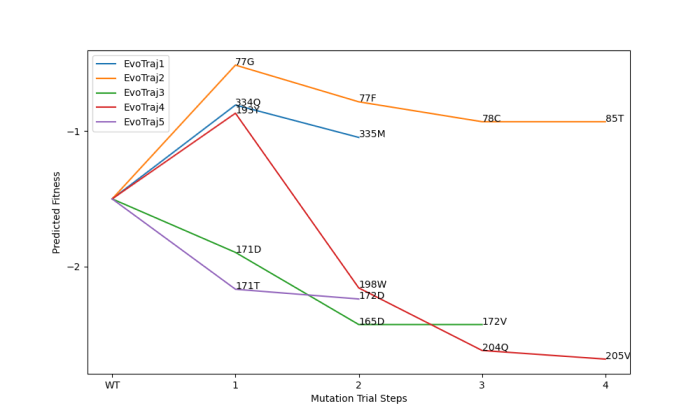


To explore deeper and/or more trajectories, one can change these parameters accordingly:

In [ ]:
%run ../../src/pypef.py directevo -m FAUJ880104 -w Sequence_WT_ANEH.fa -y -1.5 --numiter 10 --numtraj 8 --negative

To only use the data that is provided in the csv, one can define the flags `--usecsv` for just using the positions that are given in the csv data and additionally `--csvaa` to only use the substitution amino acids that are given in the csv data. 

In [ ]:
%run ../../src/pypef.py directevo -m FAUJ880104 -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fa -y -1.5 --usecsv --csvaa --negative

#### Done! End of Notebook.